In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split
import seaborn as sns


def plot_curve(epochs, hist, list_of_metrics,name):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch "+name)
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate,momentum,layers,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    #model.add(my_feature_layer)

    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=15,name='Output', activation = 'relu'))                             
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=momentum),                                       
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=my_metrics)
    return model


def train_model(model,x_data, y_data, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(value) for name, value in dataset.items()}
    history = model.fit(x=x_data, y=y_data, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle,validation_split=0.2,
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist
    
    
#returns dataframe
def test_model(model,x_data, y_data ,label_name):
    evaluation=model.evaluate(x = x_data, y = y_data, batch_size=batch_size)
    predicted = model.predict(x_data)
    df_test=pd.DataFrame(y_data,columns=[label_name])
   # print(predicted)
    df_predict=pd.DataFrame(predicted,columns=[label+"_pred" for label in label_name])
    return pd.concat([df_test,df_predict], axis=1)



In [15]:

all_labels_features=["delta","lambda","all_maxima","Intensity","overlap_s0_s2_k6a","overlap_s0_s2_k1","overlap_s0_s2_k9a"]
all_data=pd.read_csv("G:\OneDrive - bwedu\Master\Forschungspraktikum\Inga\pc-forschi\generated_Data/all_param_4_values_with_overlap.csv")
df_feature_labels=all_data[all_labels_features]

max_no_of_peak_list=max(all_data["no_of_max"])
print(max_no_of_peak_list)
df_feature_labels.head()

7


,delta,lambda,all_maxima,Intensity,overlap_s0_s2_k6a,overlap_s0_s2_k1,overlap_s0_s2_k9a
0,0.6000,0.1000,[0.466 0.54 0.612 0.67 0.742],[104.475076 104.507572 87.7231385 58.12209...,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"
1,0.6000,0.2333,[0.51 0.584 0.65 0.712 0.778],[121.232278 120.055307 85.8745546 56.17655...,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.9769, 0.0228, 0.0003, 0.0, 0.0]"
2,0.6000,0.2333,[0.482 0.556 0.628 0.686 0.756],[101.883081 101.900808 85.5862194 56.79913...,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"
3,0.5333,0.2333,[0.418 0.492 0.564 0.622 0.692],[101.197996 101.175315 85.035938 56.43656...,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"
4,0.5333,0.1000,[0.4 0.474 0.546 0.604 0.676],[104.345828 104.372914 87.6137903 58.09441...,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"


In [16]:
#convert string lists into numpy arrays in dict

all_maxima_array=np.asarray([  np.asarray([x for x in row.replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["all_maxima"] ])

intensity_array=np.asarray([  np.asarray([x for x in row.replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["Intensity"] ])

overlap_s0_s2_k6a_array=np.asarray([  np.asarray([x for x in row.replace(",","").replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["overlap_s0_s2_k6a"] ])

overlap_s0_s2_k1_array=np.asarray([  np.asarray([x for x in row.replace(",","").replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["overlap_s0_s2_k1"] ])

overlap_s0_s2_k9a_array=np.asarray([  np.asarray([x for x in row.replace(",","").replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["overlap_s0_s2_k9a"] ])

H:\Users\Gwydion\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [17]:
#pad all_maxima_array and intensity_array
all_maxima_array_padded=np.zeros((len(all_maxima_array),max_no_of_peak_list))
intensity_array_padded=np.zeros((len(intensity_array),max_no_of_peak_list))

for i in range(len(all_maxima_array)):
    for j in range(len(all_maxima_array[i])):
        all_maxima_array_padded[i][j]=all_maxima_array[i][j]
        intensity_array_padded[i][j]=intensity_array[i][j]


In [18]:
concat_label=np.concatenate((overlap_s0_s2_k6a_array,overlap_s0_s2_k1_array,overlap_s0_s2_k9a_array),axis=1)
concat_feature=np.concatenate((all_maxima_array_padded,intensity_array_padded),axis=1)

x_train, x_test,y_train,y_test = train_test_split( concat_feature, concat_label  ,test_size=0.20, random_state=42)


In [44]:
learning_rate = 1e-2
momentum=0.7
epochs = 150
batch_size = 150

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.MeanAbsoluteError()]
layers=[16,256,2048,1024,64,16]


all_label_list=["k6a 0","k6a 1","k6a 2","k6a 3","k6a 4","k1 0","k1 1","k1 2","k1 3","k1 4","k9a 0","k9a 1","k9a 2","k9a 3","k9a 4"]

my_model= create_model2(learning_rate,momentum,layers,metric,my_act_function="relu")

#lambda_train, lambda_test
#delta_train, delta_test

epochs_run, hist = train_model(my_model,x_train, y_train, epochs, 
                          all_label_list, batch_size)


Epoch 1/80

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



280/280 [==============================] - ETA: 0s - loss: 0.3006 - mean_absolute_error: 0.300 - ETA: 5s - loss: 0.2776 - mean_absolute_error: 0.277 - ETA: 6s - loss: 0.2410 - mean_absolute_error: 0.241 - ETA: 6s - loss: 0.2198 - mean_absolute_error: 0.219 - ETA: 6s - loss: 0.2056 - mean_absolute_error: 0.205 - ETA: 6s - loss: 0.1945 - mean_absolute_error: 0.194 - ETA: 7s - loss: 0.1853 - mean_absolute_error: 0.185 - ETA: 7s - loss: 0.1761 - mean_absolute_error: 0.176 - ETA: 7s - loss: 0.1687 - mean_absolute_error: 0.168 - ETA: 7s - loss: 0.1623 - mean_absolute_error: 0.162 - ETA: 7s - loss: 0.1572 - mean_absolute_error: 0.157 - ETA: 7s - loss: 0.1530 - mean_absolute_error: 0.153 - ETA: 7s - loss: 0.1493 - mean_absolute_error: 0.149 - ETA: 6s - loss: 0.1460 - mean_absolute_error: 0.146 - ETA: 6s - loss: 0.1432 - mean_absolute_error: 0.143 - ETA: 6s - loss: 0.1407 - mean_absolute_error: 0.140 - ETA: 6s - loss: 0.1385 - mean_absolute_error: 0.138 - ETA: 6s - loss: 0.1364 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0939 - mean_absolute_error: 0.093 - ETA: 5s - loss: 0.0953 - mean_absolute_error: 0.095 - ETA: 6s - loss: 0.0958 - mean_absolute_error: 0.095 - ETA: 6s - loss: 0.0957 - mean_absolute_error: 0.095 - ETA: 6s - loss: 0.0950 - mean_absolute_error: 0.095 - ETA: 6s - loss: 0.0949 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0945 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0945 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0944 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0943 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0944 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0942 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0942 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0942 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0942 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0940 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0941 - mean_absolute_error: 0.094 - ETA: 6s - loss: 0.0941 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0946 - mean_absolute_error: 0.094 - ETA: 5s - loss: 0.0934 - mean_absolute_error: 0.093 - ETA: 6s - loss: 0.0928 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0931 - mean_absolute_error: 0.093 - ETA: 6s - loss: 0.0926 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0930 - mean_absolute_error: 0.093 - ETA: 6s - loss: 0.0932 - mean_absolute_error: 0.093 - ETA: 6s - loss: 0.0931 - mean_absolute_error: 0.093 - ETA: 7s - loss: 0.0930 - mean_absolute_error: 0.093 - ETA: 7s - loss: 0.0930 - mean_absolute_error: 0.093 - ETA: 7s - loss: 0.0928 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0929 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0928 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0927 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0927 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0928 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0927 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0927 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0927 - mean_absolute_error: 0.092 - ETA: 5s - loss: 0.0927 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0925 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0922 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0920 - mean_absolute_error: 0.092 - ETA: 7s - loss: 0.0921 - mean_absolute_error: 0.092 - ETA: 7s - loss: 0.0919 - mean_absolute_error: 0.091 - ETA: 7s - loss: 0.0919 - mean_absolute_error: 0.091 - ETA: 7s - loss: 0.0919 - mean_absolute_error: 0.091 - ETA: 7s - loss: 0.0918 - mean_absolute_error: 0.091 - ETA: 7s - loss: 0.0918 - mean_absolute_error: 0.091 - ETA: 7s - loss: 0.0918 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0920 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0920 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0921 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0921 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0921 - mean_absolute_error: 0.092 - ETA: 6s - loss: 0.0922 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0904 - mean_absolute_error: 0.090 - ETA: 5s - loss: 0.0903 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0905 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0908 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0902 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0905 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0908 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0909 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0908 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0908 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0910 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0910 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0912 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0912 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0912 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0912 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0928 - mean_absolute_error: 0.092 - ETA: 5s - loss: 0.0907 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0910 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0912 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0909 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0907 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0909 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0912 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0911 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0910 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0909 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0909 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0909 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0910 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.089 - ETA: 5s - loss: 0.0906 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0907 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0903 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0902 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0904 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0903 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0903 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0904 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0904 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0904 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 5s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0895 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0898 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0898 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0902 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0908 - mean_absolute_error: 0.090 - ETA: 5s - loss: 0.0910 - mean_absolute_error: 0.091 - ETA: 6s - loss: 0.0905 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0903 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0902 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0902 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0898 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0898 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.089 - ETA: 5s - loss: 0.0906 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0902 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0898 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0901 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 7s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0898 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0899 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0895 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.089 - ETA: 5s - loss: 0.0892 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0894 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0894 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0895 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0895 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0896 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0898 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0897 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0895 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0890 - mean_absolute_error: 0.089 - ETA: 6s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0889 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0887 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0886 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0874 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 5s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 6s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0890 - mean_absolute_error: 0.089 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0885 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 5s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0884 - mean_absolute_error: 0.088 - ETA: 8s - loss: 0.0885 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0872 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0874 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.089 - ETA: 5s - loss: 0.0886 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0874 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0876 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0882 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0877 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 8s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 8s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 8s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 8s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 8s - loss: 0.0875 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0876 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0885 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0880 - mean_absolute_error: 0.088 - ETA: 7s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0878 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0877 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0872 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0869 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0900 - mean_absolute_error: 0.090 - ETA: 5s - loss: 0.0879 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0873 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 5s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 5s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0874 - mean_absolute_error: 0.087 - ETA: 5s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 6s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0849 - mean_absolute_error: 0.084 - ETA: 5s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 7s - loss: 0.0869 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0866 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0845 - mean_absolute_error: 0.084 - ETA: 5s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 5s - loss: 0.0872 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0867 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0851 - mean_absolute_error: 0.085 - ETA: 5s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 4s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0860 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0845 - mean_absolute_error: 0.084 - ETA: 5s - loss: 0.0852 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0851 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 5s - loss: 0.0874 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0868 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0876 - mean_absolute_error: 0.087 - ETA: 5s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0838 - mean_absolute_error: 0.083 - ETA: 5s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0846 - mean_absolute_error: 0.084 - ETA: 7s - loss: 0.0852 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 8s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 8s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 8s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 8s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 8s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 8s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0841 - mean_absolute_error: 0.084 - ETA: 5s - loss: 0.0845 - mean_absolute_error: 0.084 - ETA: 6s - loss: 0.0852 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 5s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0859 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0846 - mean_absolute_error: 0.084 - ETA: 6s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0837 - mean_absolute_error: 0.083 - ETA: 5s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0852 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0858 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0842 - mean_absolute_error: 0.084 - ETA: 5s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0855 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0874 - mean_absolute_error: 0.087 - ETA: 5s - loss: 0.0870 - mean_absolute_error: 0.087 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0864 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0871 - mean_absolute_error: 0.087 - ETA: 5s - loss: 0.0850 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0854 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0851 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0849 - mean_absolute_error: 0.084 - ETA: 7s - loss: 0.0852 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0853 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 5s - loss: 0.0866 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0857 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.088 - ETA: 5s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0859 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_

280/280 [==============================] - ETA: 0s - loss: 0.0846 - mean_absolute_error: 0.084 - ETA: 5s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 6s - loss: 0.0865 - mean_absolute_error: 0.086 - ETA: 6s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0861 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0862 - mean_absolute_error: 0.086 - ETA: 7s - loss: 0.0860 - mean_absolute_

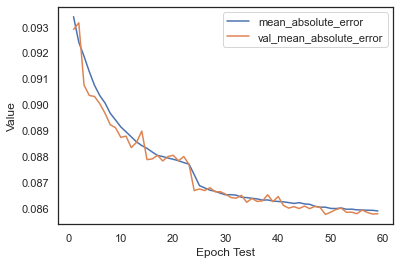

In [45]:
list_of_metrics_to_plot = ['mean_absolute_error',"val_mean_absolute_error"] 
plot_curve(epochs_run, hist, list_of_metrics_to_plot,"Test")

In [46]:
all_label_list=['k6a 0',"k6a 1","k6a 2","k6a 3","k6a 4","k1 0","k1 1","k1 2","k1 3","k1 4","k9a 0","k9a 1","k9a 2","k9a 3","k9a 4"]

delta_test_result=test_model(my_model,x_test,y_test,all_label_list)

columns_names=delta_test_result.columns

compare_k6a=columns_names[[0,1,2,3,4,15,16,17,18,19]]
compare_k1=columns_names[[5,6,7,8,9,20,21,22,23,24]]
compare_k9a=columns_names[[10,11,12,13,14,25,26,27,28,29]]
#print(compare_k6a)

#delta_test_result[compare_k6a].head(50)
#delta_test_result[compare_k1].head(50)
delta_test_result[compare_k9a].head(50)

88/88 [==============================] - ETA: 0s - loss: 0.0826 - mean_absolute_error: 0.082 - ETA: 0s - loss: 0.0863 - mean_absolute_error: 0.086 - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.085 - ETA: 0s - loss: 0.0858 - mean_absolute_error: 0.085 - 1s 8ms/step - loss: 0.0858 - mean_absolute_error: 0.0858


,"(k9a 0,)","(k9a 1,)","(k9a 2,)","(k9a 3,)","(k9a 4,)",k9a 0_pred,k9a 1_pred,k9a 2_pred,k9a 3_pred,k9a 4_pred
0,0.9769,0.0228,0.0003,0.0000,0.0000,0.947230,0.0,0.000000,0.0,0.000000
1,0.9769,0.0228,0.0003,0.0000,0.0000,0.969587,0.0,0.000000,0.0,0.000000
2,0.9769,0.0228,0.0003,0.0000,0.0000,0.957916,0.0,0.000000,0.0,0.000000
3,0.9769,0.0228,0.0003,0.0000,0.0000,0.960001,0.0,0.000000,0.0,0.000000
4,0.9769,0.0228,0.0003,0.0000,0.0000,0.959932,0.0,0.000000,0.0,0.000000
5,0.8102,0.1704,0.0180,0.0013,0.0001,0.806813,0.0,0.000000,0.0,0.000000
6,0.9769,0.0228,0.0003,0.0000,0.0000,0.981508,0.0,0.000000,0.0,0.000000
7,0.8102,0.1704,0.0180,0.0013,0.0001,0.805778,0.0,0.000000,0.0,0.000000
8,0.8102,0.1704,0.0180,0.0013,0.0001,0.805628,0.0,0.000000,0.0,0.000000
9,0.9769,0.0228,0.0003,0.0000,0.0000,0.936063,0.0,0.000000,0.0,0.000000


In [40]:
delta_test_result[compare_k9a].corr()

,"(k9a 0,)","(k9a 1,)","(k9a 2,)","(k9a 3,)","(k9a 4,)",k9a 0_pred,k9a 1_pred,k9a 2_pred,k9a 3_pred,k9a 4_pred
"(k9a 0,)",1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.917250,-0.917246,-0.339979,-0.083629,NaN
"(k9a 1,)",-1.000000,1.000000,1.000000,1.000000,1.000000,-0.917250,0.917246,0.339979,0.083629,NaN
"(k9a 2,)",-1.000000,1.000000,1.000000,1.000000,1.000000,-0.917250,0.917246,0.339979,0.083629,NaN
"(k9a 3,)",-1.000000,1.000000,1.000000,1.000000,1.000000,-0.917250,0.917246,0.339979,0.083629,NaN
"(k9a 4,)",-1.000000,1.000000,1.000000,1.000000,1.000000,-0.917250,0.917246,0.339979,0.083629,NaN
k9a 0_pred,0.917250,-0.917250,-0.917250,-0.917250,-0.917250,1.000000,-0.999769,-0.373003,-0.089656,NaN
k9a 1_pred,-0.917246,0.917246,0.917246,0.917246,0.917246,-0.999769,1.000000,0.373251,0.091467,NaN
k9a 2_pred,-0.339979,0.339979,0.339979,0.339979,0.339979,-0.373003,0.373251,1.000000,-0.029056,NaN
k9a 3_pred,-0.083629,0.083629,0.083629,0.083629,0.083629,-0.089656,0.091467,-0.029056,1.000000,NaN
k9a 4_pred,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

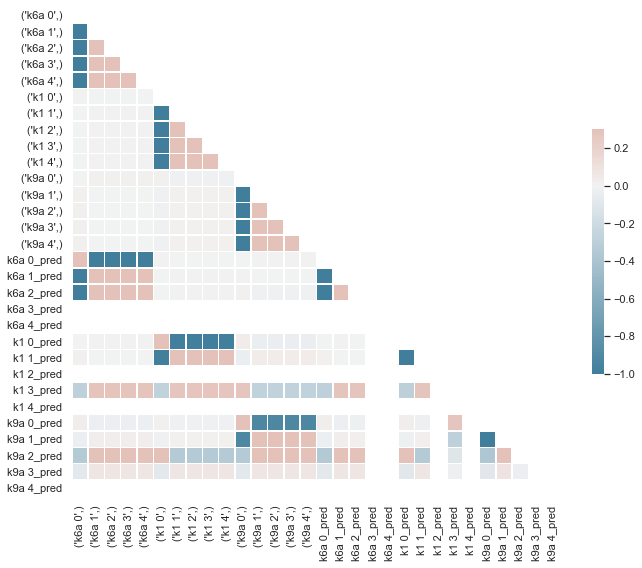

In [41]:

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = delta_test_result
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:
#my_model.save("saved_Models/model_overlap_from_spectrum_err_0_0057")

INFO:tensorflow:Assets written to: saved_Models/model_overlap_from_spectrum_err_0_0057\assets
